<a href="https://colab.research.google.com/github/jewookwak/AI/blob/master/DL_ch03_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 뉴스 기사 분류: 다중 분류 문제



# 로이터 데이터셋
- 1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합
- 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많음.
- 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있음.

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000) # num_words =10000 -> 데이터에서 가장 자주 등장하는 단어 1만 개로 제한

In [ ]:
print(len(train_data))
print(len(test_data))

8982
2246


In [ ]:
train_data[10]  # 각 샘플은 정수 리스트 (단어 인덱스)

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [ ]:
#로이터 데이터셋을 텍스트로 디코딩하기
word_index = reuters.get_word_index()
resverse_word_index = dict([(value,key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([resverse_word_index.get(i-3,'?') for i in train_data[0]])

In [ ]:
train_labels[10] # 샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수

3

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension= 10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in  enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
k = np.zeros((8982,10000))

In [ ]:
k.shape

(8982, 10000)

In [ ]:
k[0,1] = 1.
k[1,245] = 1.

In [ ]:
k

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩(categorical encoding)이라고도 부릅니다.

In [ ]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels),dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

주석 
- IMDB와 로이터 데이터셋은 미리 전체 데이터셋의 단어를 고유한 정수 인덱스로 바꾼 후에 훈련 데이터와 테스트 데이터로 나누어 놓은 것입니다. 일반적으로는 훈련 데이터에서 구축한 어휘 사전으로 테스트 세트를 변환합니다. 이렇게 하는 이유는 실전에서 샘플에 어떤 텍스트가 들어 있을지 알 수 없기 때문에 테스트 세트의 어휘를 이용하면 낙관적으로 테스트 세트를 평가하는 셈이 되기 때문입니다.
- to_one_hot() 함수는 labels 매개변수를 제외하고는 앞에 정의된 vectorize_sequences()와 동일합니다. train_data와 test_data는 파이썬 리스트의 넘파이 배열이기 때문에 to_categorical() 함수를 사용하지 못합니다. x_train과 x_test의 크기는 각각 (8982,10000), (2246,10000)이 되고 one_hot_train_labels와 one_hot_test_labels의 크기는 각각 (8982, 46). (2246, 46)이 됩니다.

In [ ]:
from keras.utils.np_utils import to_categorical  #케라스 내장 함수

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# 모델 구성
- 출력 클래스의 개수 : 2 -> 46  증가  
- 출력 공간의 차원이 훨씬 커짐.
- 정보의 병목 : 이전에 2class classification에서 처럼 Dense 층을 쌓으면, 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있기 때문에 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그다음 층에서 이를 복원할 방법이 없습니다.
- 이전 예제에서 16차원을 가진 중간층을 사용했음. 
- 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많기 때문에 병목 지점처럼 동작할 수 있음.
- 따라서 더 규모가 큰 층을 사용 -> 64개 유닛 사용.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation = 'softmax'))

- 손실 함수 : categorical_crossentropy 사용 (multi class classification 문제이기 때문)
- categorical_crossentropy는 두 확률 분포 사이의 거리를 측정
- 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리
- 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됨.


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

# 훈련 검증
훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용함.

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20번의 에포크로 모델을 훈련함.

In [ ]:
history = model.fit(partial_x_train, partial_y_train, epochs = 20, batch_size =512, validation_data=(x_val,y_val))

Epoch 1/20
16/16 [==============================] - 2s 87ms/step - loss: 2.6013 - accuracy: 0.5476 - val_loss: 1.7212 - val_accuracy: 0.6410
Epoch 2/20
16/16 [==============================] - 2s 100ms/step - loss: 1.4083 - accuracy: 0.7110 - val_loss: 1.2810 - val_accuracy: 0.7320
Epoch 3/20
16/16 [==============================] - 2s 107ms/step - loss: 1.0332 - accuracy: 0.7777 - val_loss: 1.1138 - val_accuracy: 0.7650
Epoch 4/20
16/16 [==============================] - 1s 88ms/step - loss: 0.8124 - accuracy: 0.8281 - val_loss: 1.0377 - val_accuracy: 0.7670
Epoch 5/20
16/16 [==============================] - 1s 59ms/step - loss: 0.6451 - accuracy: 0.8673 - val_loss: 0.9699 - val_accuracy: 0.7860
Epoch 6/20
16/16 [==============================] - 1s 77ms/step - loss: 0.5128 - accuracy: 0.8949 - val_loss: 0.9530 - val_accuracy: 0.8040
Epoch 7/20
16/16 [==============================] - 1s 65ms/step - loss: 0.4142 - accuracy: 0.9163 - val_loss: 0.9024 - val_accuracy: 0.8140
Epoch 8/20


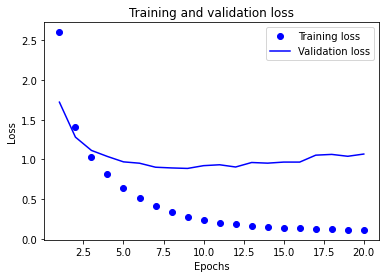

In [ ]:
import matplotlib.pyplot as plt
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

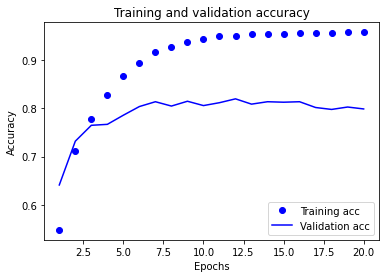

In [ ]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']

- 모델은 아홉 번째 에포크 이후에 과대적합이 시작됨.
- 아홉 번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가 진행.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=9, batch_size = 512, validation_data = (x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 70ms/step - loss: 2.6433 - accuracy: 0.5437 - val_loss: 1.7253 - val_accuracy: 0.6480
Epoch 2/9
16/16 [==============================] - 1s 55ms/step - loss: 1.3906 - accuracy: 0.7150 - val_loss: 1.2757 - val_accuracy: 0.7350
Epoch 3/9
16/16 [==============================] - 1s 54ms/step - loss: 1.0194 - accuracy: 0.7843 - val_loss: 1.1095 - val_accuracy: 0.7560
Epoch 4/9
16/16 [==============================] - 1s 54ms/step - loss: 0.7980 - accuracy: 0.8321 - val_loss: 1.0030 - val_accuracy: 0.7830
Epoch 5/9
16/16 [==============================] - 1s 52ms/step - loss: 0.6320 - accuracy: 0.8697 - val_loss: 0.9357 - val_accuracy: 0.8080
Epoch 6/9
16/16 [==============================] - 1s 54ms/step - loss: 0.5022 - accuracy: 0.8953 - val_loss: 0.8922 - val_accuracy: 0.8160
Epoch 7/9
16/16 [==============================] - 1s 54ms/step - loss: 0.4059 - accuracy: 0.9143 - val_loss: 0.8853 - val_accuracy: 0.8110
Epoch 8/9
16/16 [===

In [ ]:
results

[0.997810423374176, 0.7845057845115662]

- 대략 78%의 정확도 달성!
- 무작위로 분류했을 때 18% 정도의 정확도를 갖음. 18% << 78%

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array))/len(test_labels)

0.17853962600178094

# 새로운 데이터에 대해 예측
- 모델 객체의 predict 메서드는 46개의 토픽에대한 확률 분포를 반환
- 테스트 데이터 전체에 대한 토픽을 예측

In [ ]:
predictions = model.predict(x_test)

precdictions의 각 항목은 길이가 46인 벡터

In [ ]:
predictions[0].shape

(46,)

이 벡터의 원소 합은 1

In [ ]:
np.sum(predictions[0])

1.0000001

가장 큰 값이 예측 클래스가 됨. 즉, 가장 확률이 높은 클래스

In [ ]:
np.argmax(predictions[0])

3

# 레이블과 손실을 다루는 방법
**레이블을 인코딩하는 다른 방법** : 다음과 같이 정수 텐서로 변환

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

- 이 방식을 사용하려면 손실 함수 하나만 바꾸면 됨.
- categorical_crossentropy : 레이블이 범주형으로 인코딩 되어 있을 때 사용.  
(범주형 데이터는 'A', 'B', 'C'와 같이 종류를 표시하는 데이터를 말한다. 카테고리(category( 데이터라고도 부른다.)
- sparse_categorical_crossentropy : 레이블이 정수형으로 인코딩 되어 있을 때 사용.

In [ ]:
model.compile(optimizer='rmsprop',loss='sparse_catergorical_crossentropy',metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐 수학적으로 catergorical_crossentropy와 동일

# 충분히 큰 중간층을 두어야 하는 이유
- 병목 현상 확인

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 23ms/step - loss: 3.1373 - accuracy: 0.0712 - val_loss: 2.4442 - val_accuracy: 0.2820
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 1.9928 - accuracy: 0.5763 - val_loss: 1.7402 - val_accuracy: 0.5880
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.5179 - accuracy: 0.6257 - val_loss: 1.5369 - val_accuracy: 0.6260
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 1.3324 - accuracy: 0.6508 - val_loss: 1.4687 - val_accuracy: 0.6310
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 1.2188 - accuracy: 0.6637 - val_loss: 1.4469 - val_accuracy: 0.6570
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 1.1272 - accuracy: 0.7181 - val_loss: 1.4142 - val_accuracy: 0.6760
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.0490 - accuracy: 0.7326 - val_loss: 1.4476 - val_accuracy: 0.6860
Epoch 8/20
63

- validation 정확도 값의 최고값이 68%로 11% 감소했음.
- 정확도 하락 원인 : 많은 정보를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문.
- 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부 넣지는 못했음.

# 추가 실험
- 128개의 유닛을 사용해 더 큰 층을 구성해서 테스트

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 1.7585 - accuracy: 0.6294 - val_loss: 1.1816 - val_accuracy: 0.7350
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 0.9267 - accuracy: 0.7984 - val_loss: 0.9710 - val_accuracy: 0.8010
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 0.6087 - accuracy: 0.8691 - val_loss: 0.8942 - val_accuracy: 0.8120
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 0.4136 - accuracy: 0.9117 - val_loss: 0.9153 - val_accuracy: 0.8000
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 0.2980 - accuracy: 0.9357 - val_loss: 0.8745 - val_accuracy: 0.8270
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.2343 - accuracy: 0.9450 - val_loss: 0.9299 - val_accuracy: 0.8100
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 0.1953 - accuracy: 0.9486 - val_loss: 0.9476 - val_accuracy: 0.8150
Epoch 8/20
63

validation 데이터 최대 정확도 : 82%로 처음 분석 보다 1% 상승

- 256개의 유닛을 사용한 layer로 테스트

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 23ms/step - loss: 1.6600 - accuracy: 0.6460 - val_loss: 1.1660 - val_accuracy: 0.7430
Epoch 2/20
63/63 [==============================] - 1s 21ms/step - loss: 0.8740 - accuracy: 0.8042 - val_loss: 0.9606 - val_accuracy: 0.7940
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 0.5582 - accuracy: 0.8763 - val_loss: 0.9199 - val_accuracy: 0.7940
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 0.3709 - accuracy: 0.9173 - val_loss: 0.9277 - val_accuracy: 0.8170
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 0.2648 - accuracy: 0.9381 - val_loss: 0.9041 - val_accuracy: 0.8210
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 0.2141 - accuracy: 0.9466 - val_loss: 0.9657 - val_accuracy: 0.8090
Epoch 7/20
63/63 [==============================] - 1s 20ms/step - loss: 0.1745 - accuracy: 0.9526 - val_loss: 0.9722 - val_accuracy: 0.8140
Epoch 8/20
63

validation 데이터 정확도 :  82%로 1% 처음 테스트 보다 상승

- 3개의 은닉층을 사용해 테스트

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 23ms/step - loss: 1.8061 - accuracy: 0.6101 - val_loss: 1.2298 - val_accuracy: 0.7100
Epoch 2/20
63/63 [==============================] - 1s 20ms/step - loss: 0.9845 - accuracy: 0.7766 - val_loss: 1.0775 - val_accuracy: 0.7510
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 0.6754 - accuracy: 0.8414 - val_loss: 1.0618 - val_accuracy: 0.7510
Epoch 4/20
63/63 [==============================] - 2s 25ms/step - loss: 0.4699 - accuracy: 0.8933 - val_loss: 0.9423 - val_accuracy: 0.8100
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 0.3428 - accuracy: 0.9257 - val_loss: 0.9710 - val_accuracy: 0.8120
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.2614 - accuracy: 0.9414 - val_loss: 0.9719 - val_accuracy: 0.8160
Epoch 7/20
63/63 [==============================] - 1s 20ms/step - loss: 0.2203 - accuracy: 0.9476 - val_loss: 1.0504 - val_accuracy: 0.8020
Epoch 8/20
63

validation 데이터 정확도 : 81%으로 처음 테스트와 비슷

- 4개의 은닉층을 사용해서 테스트 진행

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 3s 24ms/step - loss: 1.8427 - accuracy: 0.5955 - val_loss: 1.3134 - val_accuracy: 0.6970
Epoch 2/20
63/63 [==============================] - 2s 26ms/step - loss: 1.0449 - accuracy: 0.7593 - val_loss: 1.1220 - val_accuracy: 0.7500
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 0.7272 - accuracy: 0.8371 - val_loss: 1.0458 - val_accuracy: 0.7890
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 0.5174 - accuracy: 0.8821 - val_loss: 1.2079 - val_accuracy: 0.7540
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 0.3776 - accuracy: 0.9121 - val_loss: 0.9992 - val_accuracy: 0.7990
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 0.2819 - accuracy: 0.9321 - val_loss: 1.4433 - val_accuracy: 0.7580
Epoch 7/20
63/63 [==============================] - 2s 27ms/step - loss: 0.2326 - accuracy: 0.9455 - val_loss: 1.1233 - val_accuracy: 0.7990
Epoch 8/20
63

validation 데이터 정확도 : 80%로 층이 깊어졌음에도 정확도 1% 하락

- 은닉층 1개로 테스트

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs=20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 1.8914 - accuracy: 0.6386 - val_loss: 1.2357 - val_accuracy: 0.7300
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 0.9469 - accuracy: 0.7988 - val_loss: 0.9800 - val_accuracy: 0.7910
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 0.6442 - accuracy: 0.8688 - val_loss: 0.8729 - val_accuracy: 0.8170
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 0.4598 - accuracy: 0.9073 - val_loss: 0.8193 - val_accuracy: 0.8220
Epoch 5/20
63/63 [==============================] - 1s 18ms/step - loss: 0.3404 - accuracy: 0.9291 - val_loss: 0.7817 - val_accuracy: 0.8390
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 0.2652 - accuracy: 0.9400 - val_loss: 0.8045 - val_accuracy: 0.8320
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 0.2133 - accuracy: 0.9466 - val_loss: 0.8310 - val_accuracy: 0.8290
Epoch 8/20
63

validaition 데이터 정확도 : 83.9%으로 가장 정확도가 높음.